In [1]:
import pickle
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from matplotlib.patches import Rectangle, Patch



sys.path.insert(0, '../4_preffect')
from _config import configs
from preffect_factory import factory
import anndata as ad 
from _inference import( Inference )

The purpose of this program is to see what happens when we adjust to a batch level while doing endogenous inference of a model

In [ ]:
# Pick file you're going to evaluate

# dataset
dataset_run = "dataset_omega_batch_1/L_Million_rprime128"

def list_subfolders(directory):
    subfolders = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    return subfolders

# created a sorting algorithm to ensure "epoch_100" is sorted after "epoch_50"
def sort_key(s):
    s = re.sub(r'\s+', '', s)
    # Extract the number from the folder name (assuming every folder name has the format 'test_<number>')
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group())
    return s

#folder_search = f'/path/to/{dataset_run}/batch_correction/'
folder_search = f'/path/to/{dataset_run}'
all_subfolders = sorted(list_subfolders(folder_search), reverse=True)

#all_subfolders.sort(key=sort_key)

#all_subfolders = all_subfolders[23:24]
all_subfolders = all_subfolders[4:5]

print("All sub-folders:", all_subfolders)

All sub-folders: ['Simple_E999_M100_NB_BatchCorr_NoMCAR_XW2_KLW01_2']


In [3]:
# Re-instate the model (models?)
configs['task'] = 'reinstate'

pr_reinstate = {}
pr_count = 0

for dir_name in all_subfolders:

    dir_name = re.sub(r'\s+', '', dir_name)
    full_path = folder_search + "/" + dir_name
    configs['output_path'] = full_path
    configs['cuda_device_num'] = 4
    pr_reinstate[pr_count] = factory(task='reinstate', configs=configs, trigger_setup=True)
    
    configs['always_save'] = False


    pr_count += 1



Now how do we repeat inference with adjust var?

In [ ]:
pr_count = 0


configs_inf = pr_reinstate[pr_count].configs.copy()
configs_inf['task'] = 'inference'

configs_inf['adjust_vars'] = True
configs_inf['adjust_to_batch_level'] = 0
print(configs_inf['inference_key'])


#inference_instance = Inference(pr_reinstate[pr_count], task='inference', inference_key = configs_inf['inference_key'], configs=configs_inf)
#inference_instance.run_inference()
#inference_instance.configs_inf['inference_key'] = 'test'
#inference_instance.register_inference_run()


infy = factory(task='inference', configs=configs_inf, 
                                                    preffect_obj=pr_reinstate[pr_count], inference_key = 'test')

In [5]:
for i in infy.inference_dict:
    print(i)

endogenous
inference_0
inference_1


Inference Type:  endogenous


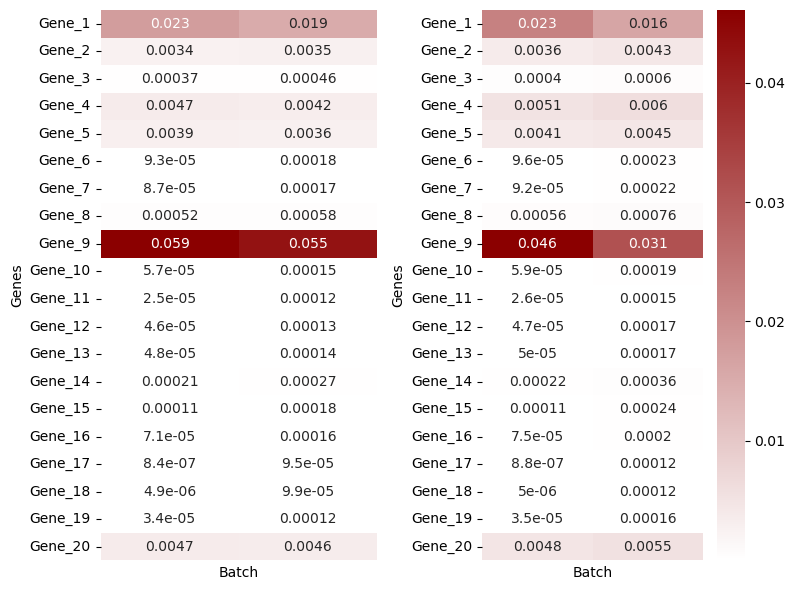

Inference Type:  inference_0


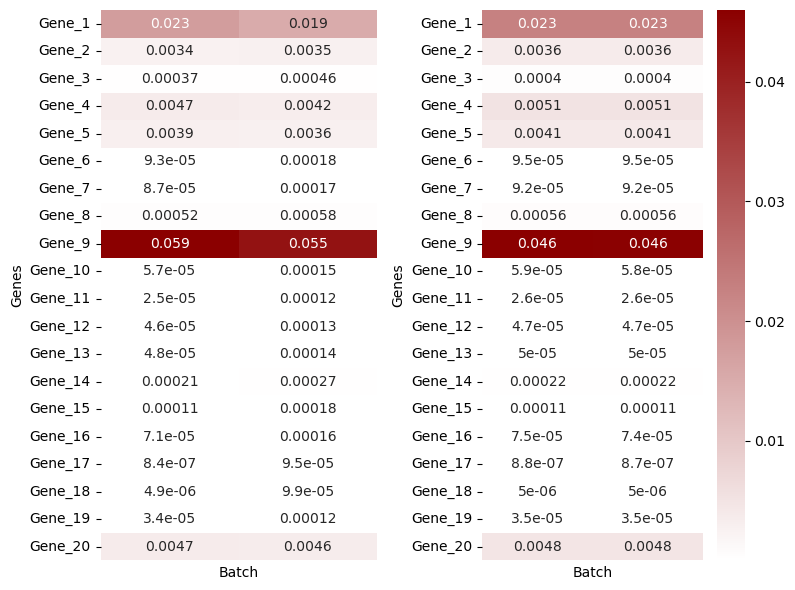

In [ ]:
counter = 0

for inf_type in infy.inference_dict:
    print("Inference Type: ", inf_type)


    white_red_cmap = LinearSegmentedColormap.from_list('white_red', ['white', 'darkred'])

    category_omegas_list, category_true_omegas_list = [], []

    inf_reinstate = infy.inference_dict[inf_type]
    adata = inf_reinstate.return_counts_as_anndata()
        
    # continuing on, lets pull Mu/Theta for this gene
    hat_mu = adata[0].X
    hat_theta = adata[0].layers["X_hat_theta"]
    true_counts = adata[0].layers["original_counts"]
            
    # lets convert true counts to omega
    library_size = np.sum(true_counts, axis=1)

    # Calculate omega (proportion of library size for each gene)
    true_omega = true_counts / library_size[:, np.newaxis]
                
    omega = adata[0].layers["px_omega"]

    batches = adata[0].obs['batch']

    gene_order = inf_reinstate.ds.gene_names

    categories = batches.cat.categories

    df = pd.DataFrame(omega, columns=[f'Gene_{i+1}' for i in range(omega.shape[1])])
    df['Batch'] = batches.to_numpy()
    category_means_omega = df.groupby('Batch').mean().T

        
    df = pd.DataFrame(true_omega, columns=[f'Gene_{i+1}' for i in range(true_omega.shape[1])])
    df['Batch'] = batches.to_numpy()
    category_means_true_omega = df.groupby('Batch').mean().T


    fig, axes = plt.subplots(1, 2, figsize=(8, 6))  # Adjust figsize as needed

    # Plot the first heatmap
    ax1 = sns.heatmap(
            category_means_true_omega[:20],
            cmap=white_red_cmap,
            cbar=False,
            xticklabels=True,
            yticklabels=True,
            ax=axes[0],
            annot=True
    )

        # Set title and labels for the first heatmap
   # ax1.set_title(r'Observed $\omega$ of Input Data')
    ax1.set_ylabel('Genes')
    ax1.set_xticks([])

        # Plot the second heatmap
    ax2 = sns.heatmap(
            category_means_omega[:20],  
            cmap=white_red_cmap,
            cbar=True,
            xticklabels=True, 
            yticklabels=True,
            ax=axes[1],
            annot=True
    )

        # Set title and labels for the second heatmap
   # plt.title(rf'$\omega$ of Inference Type: {inf_type}')# Replace with an appropriate title
    ax2.set_ylabel('Genes')
    ax2.set_xticks([])

    plt.tight_layout()

    outpath = "/path/to/heatmaps/"
    plt.savefig(outpath + "heatmap_omega." + inf_type + ".pdf", format='pdf', dpi=600)

    plt.show()

    counter += 1
    if (counter == 2):
        break



Omega after Inference Type: endogenous


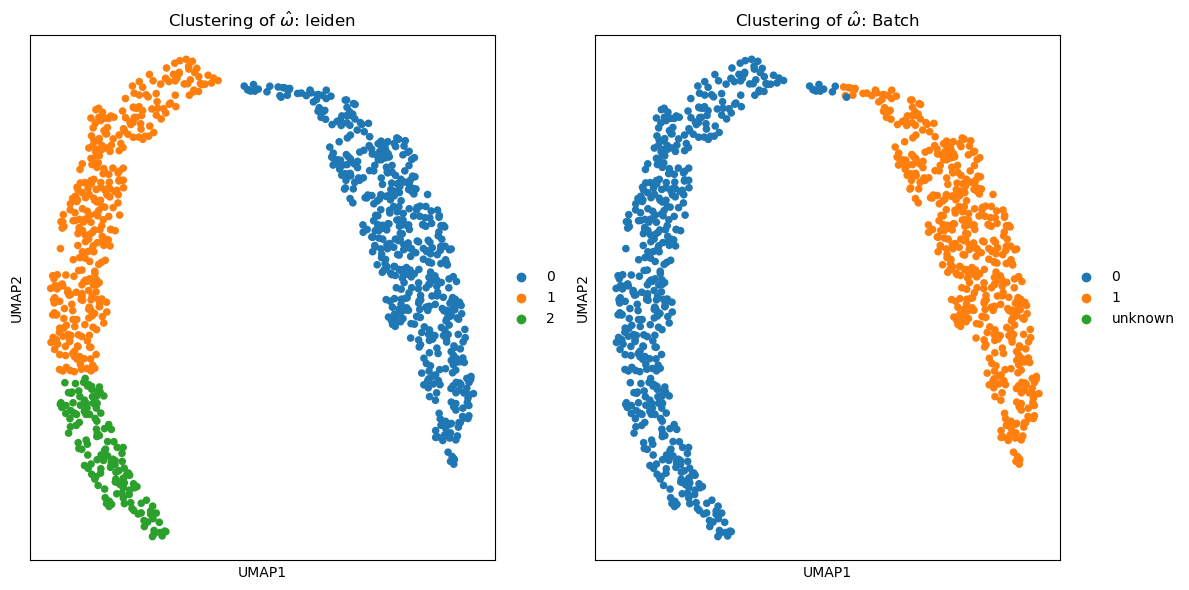

Omega after Inference Type: inference_0


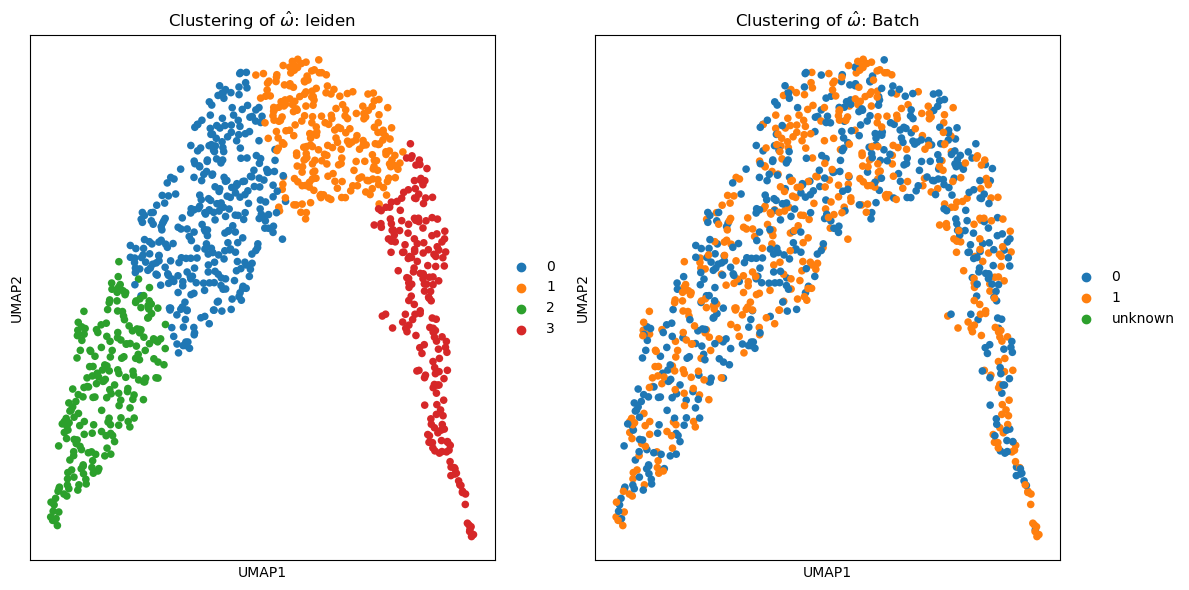

In [7]:
counter = 0

for inf_type in infy.inference_dict:
    print("Omega after Inference Type:", inf_type)
    factory(task='cluster_counts', preffect_obj=infy, inference_key=inf_type, trigger_setup=False, configs=configs)

    counter += 1
    if (counter == 2):
        break


In [ ]:
pr_count = 0


configs_inf = pr_reinstate[pr_count].configs.copy()
configs_inf['task'] = 'inference'

configs_inf['adjust_vars'] = True
configs_inf['adjust_to_batch_level'] = 1
print(configs_inf['inference_key'])


#inference_instance = Inference(pr_reinstate[pr_count], task='inference', inference_key = configs_inf['inference_key'], configs=configs_inf)
#inference_instance.run_inference()
#inference_instance.configs_inf['inference_key'] = 'test'
#inference_instance.register_inference_run()


infy = factory(task='inference', configs=configs_inf, 
                                                    preffect_obj=pr_reinstate[pr_count], inference_key = 'test_1')

Inference Type:  endogenous


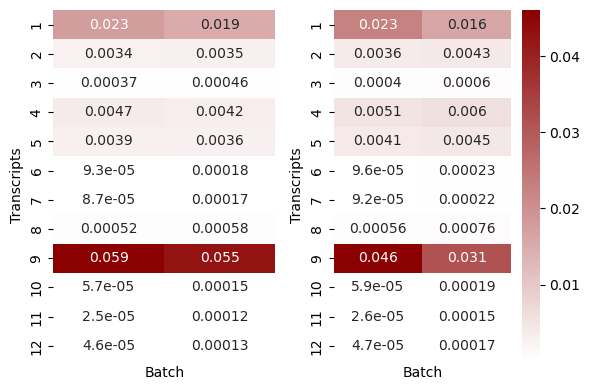

Inference Type:  inference_0


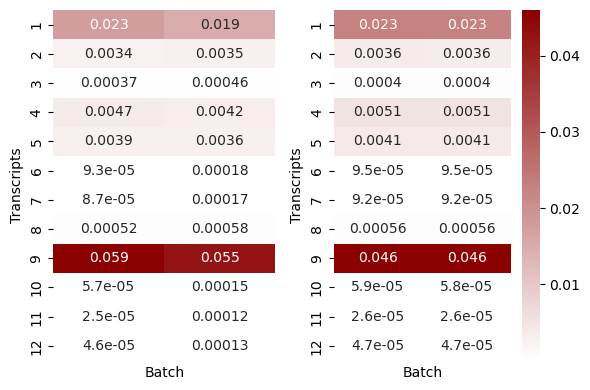

Inference Type:  inference_1


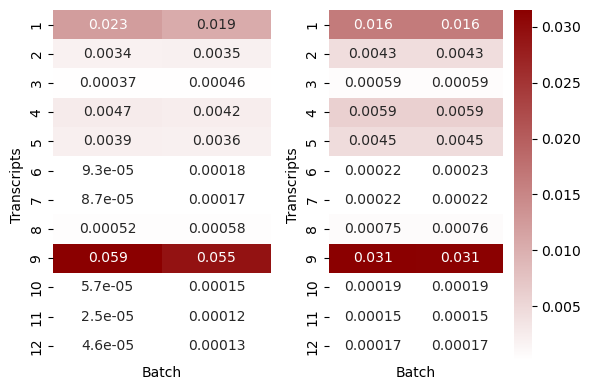

In [ ]:
for inf_type in infy.inference_dict:
    print("Inference Type: ", inf_type)


    white_red_cmap = LinearSegmentedColormap.from_list('white_red', ['white', 'darkred'])

    category_omegas_list, category_true_omegas_list = [], []

    inf_reinstate = infy.inference_dict[inf_type]
    adata = inf_reinstate.return_counts_as_anndata()
        
    # continuing on, lets pull Mu/Theta for this gene
    hat_mu = adata[0].X
    hat_theta = adata[0].layers["X_hat_theta"]
    true_counts = adata[0].layers["original_counts"]
            
    # lets convert true counts to omega
    library_size = np.sum(true_counts, axis=1)

    # Calculate omega (proportion of library size for each gene)
    true_omega = true_counts / library_size[:, np.newaxis]
                
    omega = adata[0].layers["px_omega"]

    batches = adata[0].obs['batch']

    gene_order = inf_reinstate.ds.gene_names

    categories = batches.cat.categories

    df = pd.DataFrame(omega, columns=[f'{i+1}' for i in range(omega.shape[1])])
    df['Batch'] = batches.to_numpy()
    category_means_omega = df.groupby('Batch').mean().T

        
    df = pd.DataFrame(true_omega, columns=[f'{i+1}' for i in range(true_omega.shape[1])])
    df['Batch'] = batches.to_numpy()
    category_means_true_omega = df.groupby('Batch').mean().T


    fig, axes = plt.subplots(1, 2, figsize=(6, 4))  # Adjust figsize as needed

    # Plot the first heatmap
    ax1 = sns.heatmap(
            category_means_true_omega[:12],
            cmap=white_red_cmap,
            cbar=False,
            xticklabels=True,
            yticklabels=True,
            ax=axes[0],
            annot=True
    )

        # Set title and labels for the first heatmap
    # ax1.set_title(r'Fraction of counts (generated)')
    ax1.set_ylabel('Transcripts')
    ax1.set_xticks([])

        # Plot the second heatmap
    ax2 = sns.heatmap(
            category_means_omega[:12],  
            cmap=white_red_cmap,
            cbar=True,
            xticklabels=True, 
            yticklabels=True,
            ax=axes[1],
            annot=True
    )

    text = ""

    if (inf_type == "endogenous"):
        text = "PREFFECT model"
    elif (inf_type == "inference_0"):
        text = "Adj. for Batch 0"
    elif (inf_type == "inference_1"):
        text = "Adj. for Batch 1"

        # Set title and labels for the second heatmap
    #plt.title(rf'Fraction of counts ({text})')# Replace with an appropriate title
    ax2.set_ylabel('Transcripts')
    ax2.set_xticks([])

    plt.tight_layout()

    outpath = "/path/to/2_adjust_to_batch_level/"
    plt.savefig(outpath + "heatmap_omega." + inf_type + ".pdf", format='pdf', dpi=600)

    plt.show()